# А/А-тестирование мобильного приложения


## Постановка задачи


Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

### Описание данных:


| Поле                 | Описание                |
| :--------------------| :-----------------------|
| experimentVariant    | вариант эксперимента    |
| version              | версия приложения       |
| purchase             | факт покупки            |


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale = 1.2)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('hw_aa.csv', sep=';')
print(f'Размерность данных "customers" - {df.shape}')
df.head()

Размерность данных "customers" - (127018, 5)


,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
# Посмотрим на количество уникальных значений по переменным experimentVariant и version
df[['experimentVariant', 'version']].nunique()

experimentVariant    2
version              4
dtype: int64

Таким образом, у нас 2 варианта эксперимента и 4 версии приложения.

Запустим симуляцию A/A теста и посмотрим, есть ли в наших выборках статистически значимые различия до экспериментального воздействия. Если выборки сделаны правильно тогда между двумя выборками НЕ должно быть никаких различий.

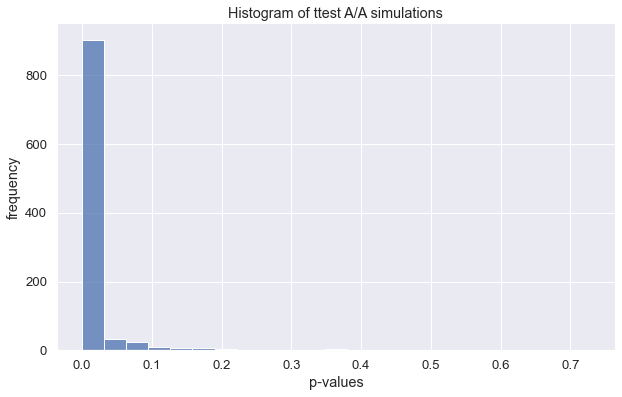

FPR value: 0.931


In [4]:
# Определим количество симуляций
simulations = 1000

# Определим размер выборки
n_s = 1000

# Определим переменную для сохранения результата
res = []

# Запуск симуляций A/A теста
for i in range(simulations):
    s1 = df[df['experimentVariant'] == 0].purchase.sample(n_s, replace = False).values    # выборка из одной группы
    s2 = df[df['experimentVariant'] == 1].purchase.sample(n_s, replace = False).values    # выборка из другой группы
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])                             # сохраняем pvalue

# Определим количество интервалов для построения гистограммы
bins = round(1 + 3.2 * np.log(len(res)))

# Визуализируем полученный результат
plt.figure(figsize=(10, 6))
ax = sns.histplot(pd.Series(res), bins=bins, kde=False)
ax.set(title='Histogram of ttest A/A simulations',
       xlabel='p-values', 
       ylabel='frequency')
sns.despine()
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print(f'FPR value: {sum(np.array(res) < 0.05) / simulations}')

**Из результата проведенной симуляции видно, что в 93% случаев мы получаем статистически значимые различия. Это подтверждает поломку  сплит-системы.**<br>

Попробуем разобратся в причине поломки. Сгруппируем данные по номеру эксперимента и версии приложения, рассчитаем конверсию и размер групп в каждом разрезе.

In [5]:
table = df.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg(conversion=('purchase', 'mean'),
         size=('uid', 'count')) \
    .pivot(index='version', columns='experimentVariant', values=['conversion', 'size'])

table['conversion'] = table['conversion'].mul(100).round(2)
table

conversion           size         
experimentVariant          0     1        0        1
version                                             
v2.8.0                  0.10  4.56  41283.0  41552.0
v2.9.0                  7.47  7.13  11921.0  12033.0
v3.7.4.0                5.99  6.30   4204.0   4221.0
v3.8.0.0                5.76  6.28   5694.0   6110.0

In [6]:
# Посмотрим какой процент составляет версия v2.8.0 в двух группах
group_0 = (table.loc[('v2.8.0', 'size')][0] / table[('size', 0)].sum())
group_1 = (table.loc[('v2.8.0', 'size')][1] / table[('size', 1)].sum())

print(f'Процент пользователей приложения v2.8.0 в эксперименте 0 - {group_0:.2%} \
        \nПроцент пользователей приложения v2.8.0 в эксперименте 1 - {group_1:.2%}')

Процент пользователей приложения v2.8.0 в эксперименте 0 - 65.42%         
Процент пользователей приложения v2.8.0 в эксперименте 1 - 65.01%


**Анализ сводной таблицы показывает, что в экспериментальную группу 0 попадают такие пользователи версии приложения `v2.8.0` у которых конверсия в покупку 0.1%, а в экспериментальную группу 1 попадают такие пользователи версии приложения `v2.8.0` у которых конверсия в покупку 4.56%. При этом на долю приложения `v2.8.0` в общей выборке по экспериментам приходится более 65% всех наблюдений. Таким образом, наша поломка, вероятнее всего, обусловлена неправильным сплитованием пользователей приложения версии `v2.8.0`**.


Для подтверждения выдвинутой гипотезы, проведем повторную симуляцию без учета приложения версии `v2.8.0`.

In [7]:
# Отфильтруем данные
sub_1 = df.query('experimentVariant == 0 & version != "v2.8.0"')
sub_2 = df.query('experimentVariant == 1 & version != "v2.8.0"')

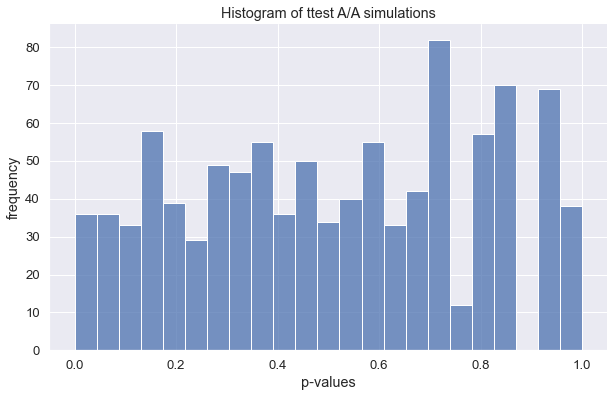

FPR value: 0.041


In [8]:
# Определим количество симуляций
simulations = 1000

# Определим размер выборки
n_s = 1000

# Определим переменную для сохранения результата
res = []

# Запуск симуляций A/A теста
for i in range(simulations):
    s1 = sub_1.purchase.sample(n_s, replace = False).values    # выборка из одной группы
    s2 = sub_2.purchase.sample(n_s, replace = False).values    # выборка из другой группы
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])  # сохраняем pvalue

# Определим количество интервалов для построения гистограммы
bins = round(1 + 3.2 * np.log(len(res)))

# Визуализируем полученный результат
plt.figure(figsize=(10, 6))
ax = sns.histplot(pd.Series(res), bins=bins, kde=False)
ax.set(title='Histogram of ttest A/A simulations',
       xlabel='p-values', 
       ylabel='frequency')
sns.despine()
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print(f'FPR value: {sum(np.array(res) < 0.05) / simulations}')

**Из результата проведенной симуляции видно, что FPR < 5%. Т.е. предположение о том, что поломка сплит-системы обусловлена неправильным сплитование пользователей приложения версии `v2.8.0` статистически доказано.**<br>